In [ ]:
# ===============================================================
# Import dan Persiapan Data
# ===============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset baru
df_robust = pd.read_csv("/content/robust_dataset_gopay.csv")

print("Jumlah data robust:", len(df_robust))
print(df_robust["sentimen"].value_counts())
df_robust.head()

Jumlah data robust: 3000
sentimen
negatif    1554
positif    1446
Name: count, dtype: int64


,reviewId,content,clean_content,at,score,sentimen
0,fb0edc5d-7167-48f7-b0f2-005d6cb607a3,mantap,mantap,2025-10-30 08:10:46,5,positif
1,7ad0dd98-8444-495d-8bd5-222e934e5f53,mantap,mantap,2025-10-30 08:07:18,5,positif
2,6d3516f1-4f19-4937-9163-6dc24549ead9,gopay mantap,gopay mantap,2025-10-30 08:05:06,5,positif
3,cdc11ab6-a2a8-4840-b83f-92f833d6ff80,gopay parah banget ga bisa bisa login ga jelas,gopay parah banget ga bisa bisa login ga jelas,2025-10-30 08:02:58,1,negatif
4,54e2150b-6d70-4f8d-a7a1-381cdcea6eb2,pembayaran qris statis bisa ke scan ganda sald...,pembayaran qris statis bisa ke scan ganda sald...,2025-10-30 08:02:47,1,negatif


In [ ]:
# Bersihkan teks
df_robust["clean_content"] = df_robust["clean_content"].astype(str).str.lower()

# Konversi label ke numerik
label_map = {"negatif": 0, "positif": 1}
df_robust["label"] = df_robust["sentimen"].map(label_map)

In [ ]:
import joblib

SVM

In [ ]:
# Load pipeline SVM (TF-IDF + classifier)
svm_pipeline = joblib.load("/content/saved_models/svm_pipeline_full.joblib")

# ===============================================================
# Evaluasi model pada data robust
# ===============================================================
y_true = df_robust["label"]
y_pred = svm_pipeline.predict(df_robust["clean_content"])

# Evaluasi
acc_svm = accuracy_score(y_true, y_pred)
f1_svm = f1_score(y_true, y_pred, average='macro')

print("=== 🧩 SVM Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_svm:.4f} | F1-macro={f1_svm:.4f}")

=== 🧩 SVM Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.85      0.82      0.83      1554
     Positif       0.81      0.84      0.83      1446

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

Accuracy=0.8287 | F1-macro=0.8286


Random Forest

In [ ]:
#===============================================================
# Load pipeline Random Forest (sudah termasuk TF-IDF)
# ===============================================================
rf_pipeline = joblib.load("/content/saved_models/rf_pipeline_full.joblib")

# ===============================================================
# Prediksi pada dataset robust
# ===============================================================
y_true = df_robust["label"]
y_pred = rf_pipeline.predict(df_robust["clean_content"])

# ===============================================================
# Evaluasi performa
# ===============================================================
acc_rf = accuracy_score(y_true, y_pred)
f1_rf = f1_score(y_true, y_pred, average='macro')

print("=== 🌲 Random Forest Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_rf:.4f} | F1-macro={f1_rf:.4f}")

=== 🌲 Random Forest Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.84      0.84      0.84      1554
     Positif       0.83      0.83      0.83      1446

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000

Accuracy=0.8367 | F1-macro=0.8364


CNN

In [ ]:
# ===============================================================
# Import Library
# ===============================================================
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, precision_recall_curve, auc

In [ ]:
# Load Dataset
df_robust = pd.read_csv("/content/robust_dataset_gopay.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Load tokenizer & model
cnn_tokenizer = joblib.load("/content/saved_models/cnn_tokenizer.pkl")
cnn_model = load_model("/content/saved_models/cnn_model_full.h5")

In [ ]:
# Gunakan kolom 'sentimen' sebagai label
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen']

In [ ]:
# ===============================================================
# Tokenisasi dan Padding
# ===============================================================
MAX_SEQUENCE_LEN = 100
X_seq = cnn_tokenizer.texts_to_sequences(df_robust["clean_content"])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

In [ ]:
# ===============================================================
# Prediksi
# ===============================================================
y_prob = cnn_model.predict(X_pad, batch_size=64).ravel()
y_pred = (y_prob >= 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluasi
acc_cnn = accuracy_score(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
roc_cnn = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_cnn = auc(recall, precision)

In [ ]:
# Tampilkan hasil
print("=== 🧩 CNN Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_cnn:.4f} | F1-macro={f1_cnn:.4f} | ROC-AUC={roc_cnn:.4f} | PR-AUC={pr_auc_cnn:.4f}")

=== 🧩 CNN Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.87      0.83      0.85      1554
     Positif       0.82      0.86      0.84      1446

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000

Accuracy=0.8453 | F1-macro=0.8453 | ROC-AUC=0.8768 | PR-AUC=0.8454


BiLSTM

In [ ]:
# ===============================================================
# BiLSTM Robust Evaluation
# ===============================================================
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, precision_recall_curve, auc

In [ ]:
# Load dataset robust
df_robust = pd.read_csv("/content/robust_dataset_gopay.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Gunakan kolom 'sentimen' sebagai label
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen']

In [ ]:
# Load BiLSTM model dan tokenizer
bilstm_model = load_model("/content/saved_models/bilstm_model_full.h5")
bilstm_tokenizer = joblib.load("/content/saved_models/bilstm_tokenizer.pkl")

In [ ]:
# Tokenisasi dan padding
MAX_SEQUENCE_LEN = 100
X_seq = bilstm_tokenizer.texts_to_sequences(df_robust["clean_content"])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

In [ ]:
# Prediksi
y_prob = bilstm_model.predict(X_pad, batch_size=64).ravel()
y_pred = (y_prob >= 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


In [ ]:
# Evaluasi
acc_bilstm = accuracy_score(y_true, y_pred)
f1_bilstm = f1_score(y_true, y_pred, average='macro')
roc_bilstm = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_bilstm = auc(recall, precision)

In [ ]:
# Hasil
print("=== 🌀 BiLSTM Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_bilstm:.4f} | F1-macro={f1_bilstm:.4f} | ROC-AUC={roc_bilstm:.4f} | PR-AUC={pr_auc_bilstm:.4f}")

=== 🌀 BiLSTM Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.86      0.78      0.82      1554
     Positif       0.79      0.87      0.82      1446

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000

Accuracy=0.8220 | F1-macro=0.8220 | ROC-AUC=0.8664 | PR-AUC=0.8084


indobert

In [ ]:
# ===============================================================
# Robust Evaluation IndoBERT Fine-tuned Model
# ===============================================================
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from tqdm import tqdm

In [ ]:
# Load dataset robust
df_robust = pd.read_csv("/content/robust_dataset_gopay.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Label encoding dari kolom 'sentimen'
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen'].values

In [ ]:
# Load IndoBERT model & tokenizer
model_path = "/content/indobert_model_full"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"🚀 Running on device: {device}")

🚀 Running on device: cpu


In [ ]:
# ===============================================================
# Tokenisasi batch
# ===============================================================
batch_size = 16
encodings = tokenizer(
    df_robust["clean_content"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]

In [ ]:
# ===============================================================
# Inference bertahap (no OOM, binary sigmoid)
# ===============================================================
probs_list = []

with torch.no_grad():
    for i in tqdm(range(0, len(input_ids), batch_size), desc="🔍 Evaluating IndoBERT"):
        batch_input = input_ids[i:i+batch_size].to(device)
        batch_mask = attention_mask[i:i+batch_size].to(device)

        outputs = model(batch_input, attention_mask=batch_mask)
        # Model binary: logits hanya 1 kolom → gunakan sigmoid
        probs = torch.sigmoid(outputs.logits).squeeze()
        probs_list.extend(probs.cpu().numpy())

🔍 Evaluating IndoBERT: 100%|██████████| 188/188 [13:51<00:00,  4.42s/it]


In [ ]:
# ===============================================================
# Evaluasi
# ===============================================================
acc_bert = accuracy_score(y_true, y_pred)
f1_bert = f1_score(y_true, y_pred, average='macro')
roc_bert = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_bert = auc(recall, precision)

In [ ]:
# ===============================================================
# Hasil akhir
# ===============================================================
print("\n=== 🤖 IndoBERT Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_bert:.4f} | F1-macro={f1_bert:.4f} | ROC-AUC={roc_bert:.4f} | PR-AUC={pr_auc_bert:.4f}")


=== 🤖 IndoBERT Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.86      0.78      0.82      1554
     Positif       0.79      0.87      0.82      1446

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000

Accuracy=0.8220 | F1-macro=0.8220 | ROC-AUC=0.8664 | PR-AUC=0.8084


visualisasi (dana : timesplit dan gopay)

In [ ]:
# ===============================================================
# Visualisasi Robustness Evaluation (DANA vs GoPay)
# ===============================================================
import matplotlib.pyplot as plt
import numpy as np

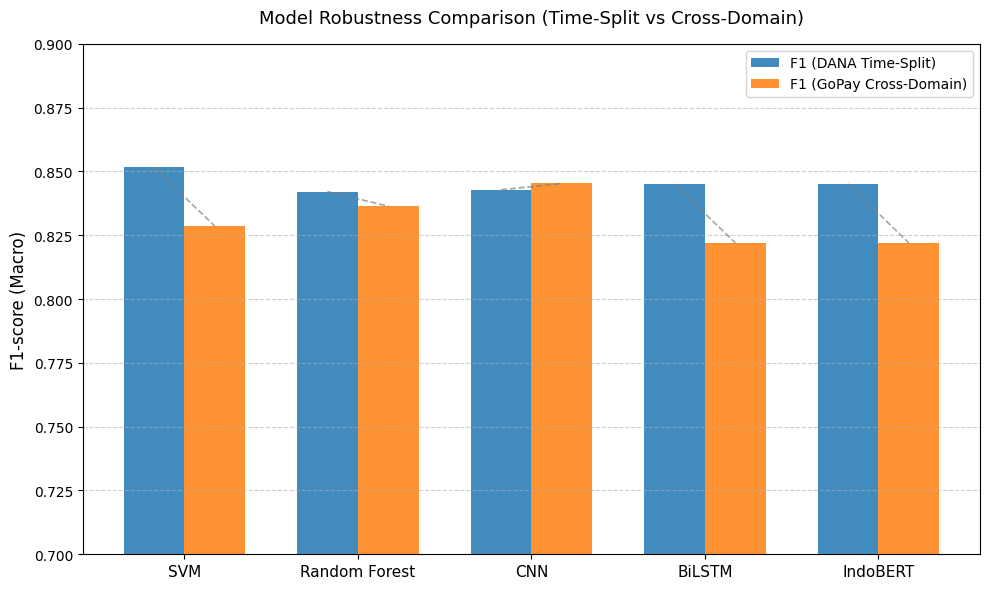

In [ ]:
# -----------------------------
# Data hasil uji dari Aisyah
# -----------------------------
models = ["SVM", "Random Forest", "CNN", "BiLSTM", "IndoBERT"]

# Time-split (DANA)
acc_dana = [0.8657, 0.8570, 0.8577, 0.8597, 0.8597]
f1_dana  = [0.8516, 0.8421, 0.8428, 0.8451, 0.8451]

# Cross-domain (GoPay)
acc_gopay = [0.8287, 0.8367, 0.8453, 0.8220, 0.8220]
f1_gopay  = [0.8286, 0.8364, 0.8453, 0.8220, 0.8220]

# -----------------------------
# Setup visualisasi
# -----------------------------
x = np.arange(len(models))  # posisi model
width = 0.35  # lebar batang

plt.figure(figsize=(10, 6))

# F1 comparison
plt.bar(x - width/2, f1_dana, width, label="F1 (DANA Time-Split)", alpha=0.85)
plt.bar(x + width/2, f1_gopay, width, label="F1 (GoPay Cross-Domain)", alpha=0.85)

# Tambahan garis pembeda
for i in range(len(models)):
    plt.plot([x[i]-width/2, x[i]+width/2],
             [f1_dana[i], f1_gopay[i]],
             color="gray", linestyle="--", linewidth=1.2, alpha=0.7)

# -----------------------------
# Label dan gaya
# -----------------------------
plt.title("Model Robustness Comparison (Time-Split vs Cross-Domain)", fontsize=13, pad=15)
plt.xticks(x, models, fontsize=11)
plt.ylabel("F1-score (Macro)", fontsize=12)
plt.ylim(0.7, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()

# -----------------------------
# Tampilkan grafik
# -----------------------------
plt.show()

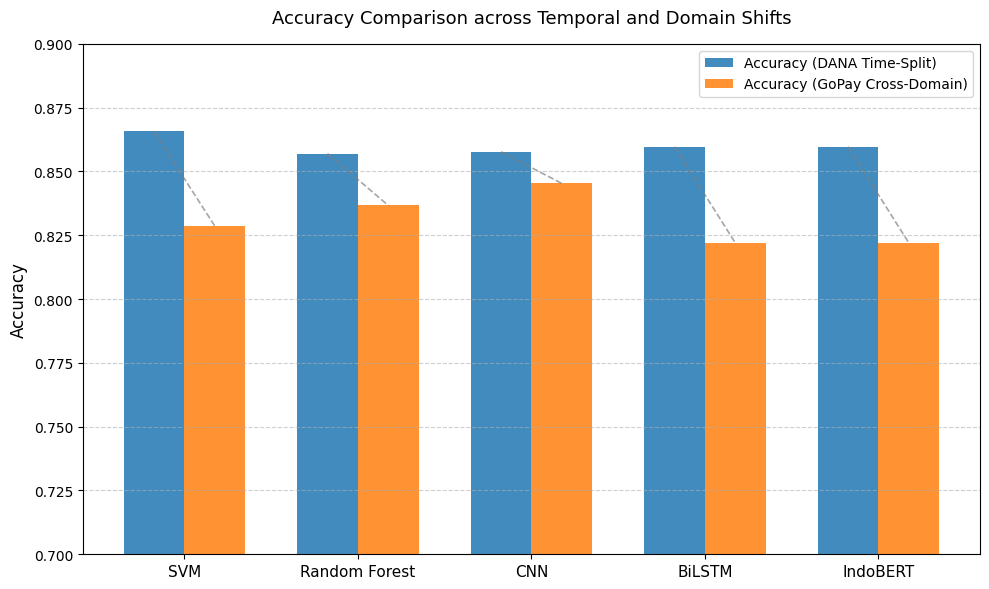

In [ ]:
# ===============================================================
# Grafik kedua untuk Accuracy
# ===============================================================
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, acc_dana, width, label="Accuracy (DANA Time-Split)", alpha=0.85)
plt.bar(x + width/2, acc_gopay, width, label="Accuracy (GoPay Cross-Domain)", alpha=0.85)

# Garis penghubung antar domain
for i in range(len(models)):
    plt.plot([x[i]-width/2, x[i]+width/2],
             [acc_dana[i], acc_gopay[i]],
             color="gray", linestyle="--", linewidth=1.2, alpha=0.7)

plt.title("Accuracy Comparison across Temporal and Domain Shifts", fontsize=13, pad=15)
plt.xticks(x, models, fontsize=11)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.7, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()